In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Colab library to upload files to notebook
from google.colab import files

In [0]:
#1. Login to your Kaggle account and under “My Account” and navigate to “Create New API Token”.
#2. Click the button to download your API token as a json file.
#3. Choose here to upload kaggle API key file named kaggle.json.
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# Install Kaggle library
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

kaggle.json


In [0]:
# Download the NYT comments from kaggle
!kaggle datasets download -d aashita/nyt-comments

 98% 471M/480M [00:07<00:00, 76.0MB/s]
100% 480M/480M [00:07<00:00, 64.3MB/s]


In [0]:
# Unzip
!unzip -q nyt-comments.zip -d nyt-comments/

In [0]:
# Keeping our dataset of interest
!mv nyt-comments/CommentsApril2017.csv Comments.csv

In [0]:
# Deleting nyt-comments and nyt-comments.zip 
!rm -rf nyt-comments
!rm nyt-comments.zip
!rm kaggle.json

# 0. USEFUL FUNCTIONS

## 0.1 Prepocessing the data

### 0.1.1 Tokenization

In [0]:
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from tqdm import tqdm
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_arroba(tokens):
  tokens = filter(lambda x: "@" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

# function to tokenize the full comment
def tokenize_fullcomment(corpus):
  # we use TweetTokenizer
  tokenizer = TweetTokenizer()
  tokenized_comments = []
  for comment in tqdm(corpus):
    tokens = tokenizer.tokenize(comment)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_arroba(tokens)
    tokens = remove_hashtags(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokenized_comments.append(tokens)
  return tokenized_comments

# function to tokenize and keep only the first sentence of each comment
def tokenize_firstsentence(corpus):
  tokenizer = TreebankWordTokenizer()  
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # keeping only the first sentence of each comment
    sentence = sent_detector.tokenize(sample)[0]
    tokens = tokenizer.tokenize(sentence)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_hashtags(tokens)
    tokens = remove_arroba(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokenized_sentences.append(tokens)
  return tokenized_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 0.1.2. Splitting the datasets

In [0]:
from sklearn.model_selection import train_test_split

def split_data(X,y):
  # creating training set 60% 
  X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42)
  # creating dev 20% test 20% (hence 50% from the 40%)
  X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)
  return(X_train, X_dev, X_test, y_train, y_dev, y_test)

### 0.1.3 Vectorizing text and labels

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

def vectorize_text(X_train, X_dev, X_test):
  cv_trained = CountVectorizer()
  X_train_cv = cv_trained.fit_transform(X_train)
  X_dev_cv = cv_trained.transform(X_dev)
  X_test_cv = cv_trained.transform(X_test)
  return(X_train_cv, X_dev_cv, X_test_cv, cv_trained)

def vectorize_label(y_train, y_dev, y_test):
  lb = preprocessing.LabelBinarizer()
  lb_trained = lb.fit(y_train)
  y_train_lb = lb_trained.transform(y_train)
  y_dev_lb = lb_trained.transform(y_dev)
  y_test_lb = lb_trained.transform(y_test)
  return(y_train_lb, y_dev_lb, y_test_lb, lb_trained)

### 0.1.4 Complete functions to preprocess the data

In [0]:
# function to completely preprocess the data
def preprocess_data(X,y):
  # tokenizing
  X = tokenize_fullcomment(X.array)
  X = [' '.join(x) for x in X]

  # splitting
  X_train, X_dev, X_test, y_train, y_dev, y_test = split_data(X,y)

  # vectorizing
  X_train_cv, X_dev_cv, X_test_cv, cv_trained = vectorize_text(X_train, X_dev, X_test)
  y_train_lb, y_dev_lb, y_test_lb, lb_trained = vectorize_label(y_train, y_dev, y_test)

  return(X_train_cv, X_dev_cv, X_test_cv, y_train_lb, y_dev_lb, y_test_lb, cv_trained, lb_trained)

In [0]:
# function to completely preprocess already splitted datasets
def preprocess_splitteddata(X_train,X_dev,X_test,y_train,y_dev,y_test):
  # tokenizing
  X_train = tokenize_fullcomment(X_train.array)
  X_test = tokenize_fullcomment(X_test.array)
  X_dev = tokenize_fullcomment(X_dev.array)
  X_train = [' '.join(x) for x in X_train]
  X_test = [' '.join(x) for x in X_test]
  X_dev = [' '.join(x) for x in X_dev]

  # vectorizing
  X_train_cv, X_dev_cv, X_test_cv, cv_trained = vectorize_text(X_train, X_dev, X_test)
  y_train_lb, y_dev_lb, y_test_lb, lb_trained = vectorize_label(y_train, y_dev, y_test)

  return(X_train_cv, X_dev_cv, X_test_cv, y_train_lb, y_dev_lb, y_test_lb, cv_trained, lb_trained)

## 0.2 Predicting sentiments

### 0.2.1 Predicting with SVM

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

def predict_svm(X_train_cv, y_train_lb, X_dev_cv):
  svm = LinearSVC(verbose=1, random_state=42)
  clf_svm = OneVsRestClassifier(svm, n_jobs=1 ).fit(X_train_cv.toarray(), y_train_lb)
  y_pred_svm = clf_svm.predict(X_dev_cv)
  return(y_pred_svm)

### 0.2.2 Predicting with Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

def predict_randomforest(X_train_cv, y_train_lb, X_dev_cv):
  rfc = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1)
  rfc.fit(X_train_cv, y_train_lb)
  y_pred_rfc = rfc.predict(X_dev_cv)
  return(y_pred_rfc)

### 0.2.3 Evaluating predictions

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

def show_eval(y_true, y_pred, lb_trained, labels):
  
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print("/n")
  print( classification_report(y_true_names, y_pred_names) )

  cm = confusion_matrix(y_true_names, y_pred_names) 
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)

  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. COMMENTS LABELLISATION WITH A DICTIONARY OF SENTIMENTS

## 1.1 Positive and negative labelling with opinion_lexicon

*   Downloading comments' dataframe




In [0]:
comments = pd.read_csv('Comments.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


*   Data cleaning

We remove all the comments with cell in the column 'sectionName' equals to 'Unknown'.



In [0]:
lines = []
for i in range(len(comments.sectionName)):
  if comments.sectionName[i] == 'Unknown':
      lines.append(i)
comments.drop(lines, inplace=True)

*   Creating comments_one

We create a new database selecting only the first sentence of the comment.

In [0]:
import nltk
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
sent_detector._params.abbrev_types.add('hon')

comments_one = comments.copy()
corpus = []
for k in comments.index:
  corpus = sent_detector.tokenize(comments.commentBody[k])
  comments_one.commentBody[k] = corpus[0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


*    Importing tokenization packages and dictionaries

In [0]:
import nltk
nltk.download('opinion_lexicon')
from nltk.tokenize import treebank
from nltk.corpus import opinion_lexicon
tokenizer = treebank.TreebankWordTokenizer()

pos_dictionary = set(opinion_lexicon.positive())
neg_dictionary = set(opinion_lexicon.negative())

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


*   Labelling function

The '<', 'br/', '>', '@' are deleted during tokenization.

The labels column is called 'sentiment'.

In [0]:
def sentiment_count(sentence):
  count = 0
  words = [word.lower() for word in tokenizer.tokenize(sentence)]
  words = [x for x in words if x != ('<' or 'br/' or '<' or '@')]
  for k in words:
    if k in pos_dictionary:
      count += 1
    elif k in neg_dictionary:
      count -= 1
  return count

In [0]:
comments['sentiment'] = comments['commentBody'].apply(sentiment_count)
comments_one['sentiment'] = comments_one['commentBody'].apply(sentiment_count)

A positive comment is labelled 1 and a negative comment is labelled 0.

In [0]:
for k in comments.index:
  if comments['sentiment'][k] > 0:
    comments['sentiment'][k] = '1'
  else:
    comments['sentiment'][k] = '0'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
for k in comments_one.index:
  if comments_one['sentiment'][k] > 0:
    comments_one['sentiment'][k] = '1'
  else:
    comments_one['sentiment'][k] = '0'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


*   Selection of comment and label columns

The '<', 'br/', '<', '@' are deleted.

Characters are lowercase.

In [0]:
X = comments[["commentBody", "sentiment"]]
X['commentBody'] = X['commentBody'].str.replace('<br/>', ' ').str.replace('@', '')
X['commentBody'] = X['commentBody'].str.lower()
X

print(X)
print(X.shape)

                                              commentBody  sentiment
900     it's not clear that athletic administrators at...          0
901     i recognize a hit piece full of carefully word...          0
902     the timing of this article is repulsive.  fina...          0
903     who cares? it is the strange ncaa structure an...          1
904     how are these guys even in the tournament? dis...          0
...                                                   ...        ...
243772  yes, i had to freeze frame to catch that one, ...          0
243773  the best version of that song is by utah phill...          1
243774  according to redditor thedrudo it is damon lin...          1
243775  is kevin happy? his answer strikes me as sound...          1
243776  his explanation seemed like a complete lie to ...          1

[105904 rows x 2 columns]
(105904, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
X_one = comments_one[["commentBody", "sentiment"]]
X_one['commentBody'] = X_one['commentBody'].str.replace('<br/>', ' ').str.replace('@', '')
X_one['commentBody'] = X_one['commentBody'].str.lower()
X_one

print(X_one)
print(X_one.shape)

                                              commentBody  sentiment
900     it's not clear that athletic administrators at...          1
901     i recognize a hit piece full of carefully word...          0
902              the timing of this article is repulsive.          0
903                                            who cares?          0
904     how are these guys even in the tournament? dis...          0
...                                                   ...        ...
243772  yes, i had to freeze frame to catch that one, ...          0
243773  the best version of that song is by utah phill...          1
243774  according to redditor thedrudo it is damon lin...          0
243775                                    is kevin happy?          1
243776  his explanation seemed like a complete lie to me.          0

[105904 rows x 2 columns]
(105904, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


*    Creating trainset, testset and devtest splitting the dataframes

In [0]:
from sklearn.model_selection import train_test_split

train, devtest = train_test_split(X, test_size=0.4, random_state=42)
dev, test = train_test_split(devtest, test_size=0.5, random_state=42)

train_one, devtest_one = train_test_split(X_one, test_size=0.4, random_state=42)
dev_one, test_one = train_test_split(devtest_one, test_size=0.5, random_state=42)

*   Export of the different dataset in .csv format

In [0]:
from google.colab import files

train.to_csv('train.csv', sep='\t', index=False)
dev.to_csv('dev.csv', sep='\t', index=False)
test.to_csv('test.csv', sep='\t', index=False)

train_one.to_csv('train_one.csv', sep='\t', index=False)
dev_one.to_csv('dev_one.csv', sep='\t', index=False)
test_one.to_csv('test_one.csv', sep='\t', index=False)

## 1.2. Sentiment labelling with NRC-emotion-lexicon

The study is restricted to 20,000 comments, because the labeling with sentiments is rather long. To be changed according to the user's wishes.

In [0]:
comments = pd.read_csv('Comments.csv')
comments = comments[:20000]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


*   Data cleaning

We remove all the comments with cell in the column 'sectionName' equals to 'Unknown'.



In [0]:
lines = []
for i in range(len(comments.sectionName)):
  if comments.sectionName[i] == 'Unknown':
      lines.append(i)
comments.drop(lines, inplace=True)

*   Creating comments_one

We create a new database selecting only the first sentence of the comment.

In [0]:
import nltk
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
sent_detector._params.abbrev_types.add('hon')

comments_one = comments.copy()
corpus = []
for k in comments.index:
  corpus = sent_detector.tokenize(comments.commentBody[k])
  comments_one.commentBody[k] = corpus[0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


*    Importing tokenization packages


In [0]:
import nltk
nltk.download('punkt')
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


*   Downloading NRC emotion lexicon

In [0]:
!wget 'https://raw.githubusercontent.com/sebastianruder/emotion_proposition_store/master/NRC-Emotion-Lexicon-v0.92/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt'

--2020-04-12 10:35:09--  https://raw.githubusercontent.com/sebastianruder/emotion_proposition_store/master/NRC-Emotion-Lexicon-v0.92/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2580190 (2.5M) [text/plain]
Saving to: ‘NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt’

NRC-emotion-lexicon 100%[===================>]   2.46M  --.-KB/s    in 0.03s   

2020-04-12 10:35:10 (73.8 MB/s) - ‘NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt’ saved [2580190/2580190]



*   Labelling function

Adds 10 columns to the dataframe for each of the 10 emotions in the NRC Emotion Lexicon ('anger', 'anticipation', 'disgust', 'fear', 'negative', 'positive', 'surprise', 'sadness', 'joy', 'trust'), with each column containing the value of the text in that emotions.

The execution of this function can be rather long.

In [0]:
def text_emotion(df, column):
    new_df = df.copy()
    emolex_df = pd.read_csv('NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt',
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot_table(index='word', columns='emotion',
                                   values='association')
    emolex_words = emolex_words.reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")


    with tqdm(total=len(list(new_df.iterrows()))) as pbar:
        for i, row in new_df.iterrows():
            pbar.update(1)
            document = word_tokenize(new_df.loc[i][column])
            for w in document:
                w = stemmer.stem(w.lower())
                emo_top = emolex_words.head()
                emo_score = emolex_words[emolex_words.word == w]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df

In [0]:
comments = text_emotion(comments, 'commentBody')
comments_one = text_emotion(comments_one, 'commentBody')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


*   Keeping only four emotions

For each comment, a corresponding emotion is selected by selecting the emotion with the highest score.


In [0]:
comments['sentiment'] = comments[['anger', 'anticipation', 'disgust', 'fear', 'negative', 'positive', 'surprise', 'sadness', 'joy', 'trust']].idxmax(axis=1)
comments_one['sentiment'] = comments_one[['anger', 'anticipation', 'disgust', 'fear', 'negative', 'positive', 'surprise', 'sadness', 'joy', 'trust']].idxmax(axis=1)

For greater clarity and relevance, we group the emotions according to the following diagram:
- 'positive' is absorbed by 'joy' ;
- 'disgust' and 'surprise' are absorbed by 'anger' ;
- 'negative' and 'fear' are absorbed by 'sadness' ;
- 'anticipation' is absorbed by 'trust'.


In [0]:
comments = comments.replace(["positive"],"joy")
comments = comments.replace(["disgust", "surprise"],"anger")
comments = comments.replace(["negative", "fear"],"sadness")
comments = comments.replace(["anticipation"],"trust")

comments_one = comments_one.replace(["positive"],"joy")
comments_one = comments_one.replace(["disgust", "surprise"],"anger")
comments_one = comments_one.replace(["negative", "fear"],"sadness")
comments_one = comments_one.replace(["anticipation"],"trust")

In [0]:
comments_one.sentiment.value_counts()

anger      4337
joy        2231
trust      2018
sadness    1880
Name: sentiment, dtype: int64

In [0]:
comments.sentiment.value_counts()

joy        3489
sadness    2816
trust      2199
anger      1962
Name: sentiment, dtype: int64

A positive comment is labelled 1 and a negative comment is labelled 0.

In [0]:
for k in comments.index:
  if comments['sentiment'][k] == 'anger':
    comments['anger'][k] = 1
  else:
    comments['anger'][k] = 0
  if comments['sentiment'][k] == 'sadness':
    comments['sadness'][k] = 1
  else:
    comments['sadness'][k] = 0
  if comments['sentiment'][k] == 'trust':
    comments['trust'][k] = 1
  else:
    comments['trust'][k] = 0
  if comments['sentiment'][k] == 'joy':
    comments['joy'][k] = 1
  else:
    comments['joy'][k] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithC

In [0]:
for k in comments_one.index:
  if comments_one['sentiment'][k] == 'anger':
    comments_one['anger'][k] = 1
  else:
    comments_one['anger'][k] = 0
  if comments_one['sentiment'][k] == 'sadness':
    comments_one['sadness'][k] = 1
  else:
    comments_one['sadness'][k] = 0
  if comments_one['sentiment'][k] == 'trust':
    comments_one['trust'][k] = 1
  else:
    comments_one['trust'][k] = 0
  if comments_one['sentiment'][k] == 'joy':
    comments_one['joy'][k] = 1
  else:
    comments_one['joy'][k] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithC

*   Selection of comment and label columns

The '<', 'br/', '<', '@' are deleted.

Characters are lowercase.

In [0]:
X = comments[["commentBody", "anger", "sadness", "trust", "joy"]]
X['commentBody'] = X['commentBody'].str.replace('<br/>', ' ').str.replace('@', '')
X['commentBody'] = X['commentBody'].str.lower()
X

print(X)
print(X.shape)

                                             commentBody  anger  ...  trust  joy
900    it's not clear that athletic administrators at...      0  ...      0    0
901    i recognize a hit piece full of carefully word...      0  ...      0    1
902    the timing of this article is repulsive.  fina...      0  ...      1    0
903    who cares? it is the strange ncaa structure an...      0  ...      1    0
904    how are these guys even in the tournament? dis...      1  ...      0    0
...                                                  ...    ...  ...    ...  ...
17442  it is the school  that cheated and should be p...      0  ...      0    0
17443  michael, you undermine your credibility by ove...      1  ...      0    0
17444  what about the players, do the get anything ou...      0  ...      0    0
17445  worth the wait. but not the academic cheating ...      0  ...      0    0
17446  i agree.  i love carolina.  both of my daughte...      0  ...      1    0

[10466 rows x 5 columns]
(1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
X_one = comments_one[["commentBody", "anger", "sadness", "trust", "joy"]]
X_one['commentBody'] = X_one['commentBody'].str.replace('<br/>', ' ').str.replace('@', '')
X_one['commentBody'] = X_one['commentBody'].str.lower()
X_one

print(X_one)
print(X_one.shape)

                                             commentBody  anger  ...  trust  joy
900    it's not clear that athletic administrators at...      0  ...      0    0
901    i recognize a hit piece full of carefully word...      0  ...      0    1
902             the timing of this article is repulsive.      0  ...      1    0
903                                           who cares?      1  ...      0    0
904    how are these guys even in the tournament? dis...      1  ...      0    0
...                                                  ...    ...  ...    ...  ...
17442  it is the school  that cheated and should be p...      0  ...      0    0
17443  michael, you undermine your credibility by ove...      1  ...      0    0
17444  what about the players, do the get anything ou...      0  ...      0    0
17445                                    worth the wait.      0  ...      1    0
17446                                           i agree.      1  ...      0    0

[10466 rows x 5 columns]
(1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


*    Creating trainset, testset and devtest splitting the dataframes

In [0]:
from sklearn.model_selection import train_test_split

train, devtest = train_test_split(X, test_size=0.4, random_state=42)
dev, test = train_test_split(devtest, test_size=0.5, random_state=42)

train_one, devtest_one = train_test_split(X_one, test_size=0.4, random_state=42)
dev_one, test_one = train_test_split(devtest_one, test_size=0.5, random_state=42)

*   Export of the different dataset in .csv format

In [0]:
from google.colab import files

train.to_csv('train_sentiment.csv', sep='\t', index=False)
dev.to_csv('dev_sentiment.csv', sep='\t', index=False)
test.to_csv('test_sentiment.csv', sep='\t', index=False)

train_one.to_csv('train_one_sentiment.csv', sep='\t', index=False)
dev_one.to_csv('dev_one_sentiment.csv', sep='\t', index=False)
test_one.to_csv('test_one_sentiment.csv', sep='\t', index=False)

# 2. TEXT CLASSIFICATION WITH A DATASET OF LABELLED TWEETS

We need a dataset with labelled comments in order to train our algorithms. We tried different methods to get these labels: the first method was to assign a label to comments thanks to dictionaries, the second one is to use a dataset with labels available online.
We chose the following dataset by CrowdFlower of tweets categorised in 13 different emotions.

In [54]:
!wget http://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv

--2020-04-12 11:36:13--  http://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv
Resolving www.crowdflower.com (www.crowdflower.com)... 50.19.52.239, 34.238.175.195, 54.164.251.168
Connecting to www.crowdflower.com (www.crowdflower.com)|50.19.52.239|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.figure-eight.com/wp-content/uploads/2016/07/text_emotion.csv [following]
--2020-04-12 11:36:13--  https://www.figure-eight.com/wp-content/uploads/2016/07/text_emotion.csv
Resolving www.figure-eight.com (www.figure-eight.com)... 54.84.239.168, 54.86.123.68
Connecting to www.figure-eight.com (www.figure-eight.com)|54.84.239.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4394791 (4.2M) [application/octet-stream]
Saving to: ‘text_emotion.csv’

text_emotion.csv    100%[===================>]   4.19M  6.82MB/s    in 0.6s    

2020-04-12 11:36:14 (6.82 MB/s) - ‘text_emotion.csv’ saved [4394791/4394791]


In [55]:
dfTweets = pd.read_csv('text_emotion.csv')
X = dfTweets.content
y = dfTweets.sentiment
y.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [56]:
# preprocessing the data
X_train_cv, X_dev_cv, X_test_cv, y_train_lb, y_dev_lb, y_test_lb, cv_trained, lb_trained = preprocess_data(X,y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/n
              precision    recall  f1-score   support

       anger       0.00      0.38      0.01        26
     boredom       0.00      0.00      0.00        35
       empty       0.02      0.01      0.01       169
  enthusiasm       0.02      0.01      0.01       161
         fun       0.07      0.04      0.05       320
   happiness       0.28      0.16      0.20      1014
        hate       0.23      0.15      0.18       255
        love       0.38      0.23      0.29       773
     neutral       0.32      0.19      0.24      1708
      relief       0.07      0.02      0.03       321
     sadness       0.30      0.16      0.21      1051
    surprise       0.16      0.05      0.07       439
       worry       0.36      0.18      0.24      1728

    accuracy                           0.16      8000
   macro avg       0.17      0.12      0.12      8000
weighted avg       0.28      0.16      0.20      8000



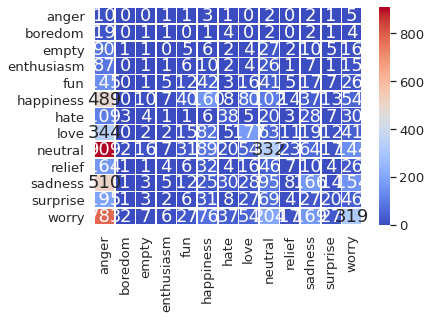

In [57]:
# predicting the labels and evaluating the predictions
y_pred_svm = predict_svm(X_train_cv, y_train_lb, X_dev_cv)
labels = ['anger', 'boredom', 'empty','enthusiasm','fun','happiness','hate','love','neutral','relief','sadness','surprise','worry']
show_eval(y_dev_lb, y_pred_svm, lb_trained, labels)

We can see that these 13 categories are not relevant because it is hard to distinguish the lines between them. Therefore, we decide to limit the emotions in four categories : *anger*, *sadness*, *trust* et *joy*.

## 2.1 Sentiment analysis with 4 emotions

In [58]:
# limiting sentiments to sadness, anger, trust and joy
y = dfTweets.sentiment
y = y.replace(["worry","surprise"],"sadness")
y = y.replace(["boredom","empty","hate","fun","relief","neutral"],"anger")
y = y.replace(["enthusiasm","love"],"trust")
y = y.replace(["happiness"],"joy")
y.value_counts()

sadness    15811
anger      14379
joy         5209
trust       4601
Name: sentiment, dtype: int64

### 2.1.1 Training algotithms with labelled tweets

In [59]:
# preprocessing the data
X_train_cv, X_dev_cv, X_test_cv, y_train_lb, y_dev_lb, y_test_lb, cv_trained, lb_trained = preprocess_data(X,y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[LibLinear][LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/n
              precision    recall  f1-score   support

       anger       0.41      0.66      0.51      2834
         joy       0.30      0.15      0.20      1014
     sadness       0.60      0.47      0.52      3218
       trust       0.41      0.19      0.26       934

    accuracy                           0.46      8000
   macro avg       0.43      0.37      0.37      8000
weighted avg       0.47      0.46      0.45      8000



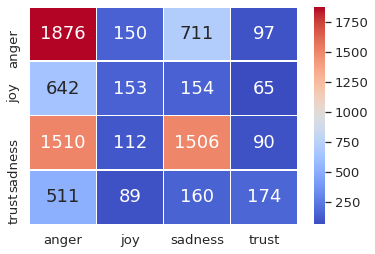

In [60]:
# predicting the labels and evaluating the predictions
y_pred_svm = predict_svm(X_train_cv, y_train_lb, X_dev_cv)
labels = ['anger', 'joy', 'sadness','trust']
show_eval(y_dev_lb, y_pred_svm, lb_trained, labels)

### 2.1.1 Testing on the annoted comments

We are going to test the predictions of the model on our dataset. For that, we manually annotated 160 comments with the four emotions. We are going to see if the predictions work well on these 160 comments.

In [61]:
comments= pd.read_csv('Comments.csv')
comments.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(243832, 34)

In [62]:
# keeping only comments that have the name of the article's section
comments = comments[comments['sectionName']!="Unknown"]
comments["sentiment"] = np.nan
comments = comments[["commentBody","sentiment"]]
comments.head()

,commentBody,sentiment
900,It's not clear that athletic administrators at...,NaN
901,I recognize a hit piece full of carefully word...,NaN
902,The timing of this article is repulsive. Fina...,NaN
903,Who cares? It is the strange NCAA structure an...,NaN
904,How are these guys even in the tournament?<br/...,NaN


In [63]:
# we code -2 sadness, -1 anger, 1 trust and 2 joy 
i = 0
comments.sentiment.iloc[i+1] = -1
comments.sentiment.iloc[i+2] = -1
comments.sentiment.iloc[i+3] = -1
comments.sentiment.iloc[i+4] = -1
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = -1
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = -1
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -1

i = 10
comments.sentiment.iloc[i+1] = -2
comments.sentiment.iloc[i+2] = 1
comments.sentiment.iloc[i+3] = 1
comments.sentiment.iloc[i+4] = 1
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = -2
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = 1
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -2

i = 20
comments.sentiment.iloc[i+1] = -1
comments.sentiment.iloc[i+2] = -1
comments.sentiment.iloc[i+3] = 1
comments.sentiment.iloc[i+4] = 1
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = -1
comments.sentiment.iloc[i+7] = -2
comments.sentiment.iloc[i+8] = 1
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -1

i = 30
comments.sentiment.iloc[i+1] = 2
comments.sentiment.iloc[i+2] = -1
comments.sentiment.iloc[i+3] = -1
comments.sentiment.iloc[i+4] = 1
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = -1
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = 2
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -2

i = 1000
comments.sentiment.iloc[i+1] = 1
comments.sentiment.iloc[i+2] = -1
comments.sentiment.iloc[i+3] = -2
comments.sentiment.iloc[i+4] = -2
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = 1
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = -1
comments.sentiment.iloc[i+9] = 1
comments.sentiment.iloc[i+10] = -2

i = 1010
comments.sentiment.iloc[i+1] = -1
comments.sentiment.iloc[i+2] = -2
comments.sentiment.iloc[i+3] = -1
comments.sentiment.iloc[i+4] = -1
comments.sentiment.iloc[i+5] = 1
comments.sentiment.iloc[i+6] = -1
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = 1
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -1

i = 1020
comments.sentiment.iloc[i+1] = -1
comments.sentiment.iloc[i+2] = -1
comments.sentiment.iloc[i+3] = -2
comments.sentiment.iloc[i+4] = -1
comments.sentiment.iloc[i+5] = -2
comments.sentiment.iloc[i+6] = -1
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = -1
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -1

i = 1030
comments.sentiment.iloc[i+1] = -1
comments.sentiment.iloc[i+2] = -1
comments.sentiment.iloc[i+3] = -1
comments.sentiment.iloc[i+4] = -1
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = -1
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = -1
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -1

i = 50000
comments.sentiment.iloc[i+1] = 1
comments.sentiment.iloc[i+2] = 1
comments.sentiment.iloc[i+3] = 1
comments.sentiment.iloc[i+4] = 1
comments.sentiment.iloc[i+5] = 1
comments.sentiment.iloc[i+6] = 1
comments.sentiment.iloc[i+7] = 2
comments.sentiment.iloc[i+8] = 1
comments.sentiment.iloc[i+9] = 1
comments.sentiment.iloc[i+10] = 1

i = 50010
comments.sentiment.iloc[i+1] = 1
comments.sentiment.iloc[i+2] = -2
comments.sentiment.iloc[i+3] = -1
comments.sentiment.iloc[i+4] = 1
comments.sentiment.iloc[i+5] = 2
comments.sentiment.iloc[i+6] = -1
comments.sentiment.iloc[i+7] = 1
comments.sentiment.iloc[i+8] = 1
comments.sentiment.iloc[i+9] = -2
comments.sentiment.iloc[i+10] = 2

i = 55000
comments.sentiment.iloc[i+1] = -1
comments.sentiment.iloc[i+2] = 1
comments.sentiment.iloc[i+3] = -1
comments.sentiment.iloc[i+4] = -1
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = -2
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = -1
comments.sentiment.iloc[i+9] = -2
comments.sentiment.iloc[i+10] = 1

i = 55010
comments.sentiment.iloc[i+1] = -2
comments.sentiment.iloc[i+2] = -1
comments.sentiment.iloc[i+3] = -1
comments.sentiment.iloc[i+4] = -1
comments.sentiment.iloc[i+5] = 1
comments.sentiment.iloc[i+6] = 1
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = -1
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -1

i = 80000
comments.sentiment.iloc[i+1] = -1
comments.sentiment.iloc[i+2] = -1
comments.sentiment.iloc[i+3] = 1
comments.sentiment.iloc[i+4] = -2
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = 1
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = 2
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = 1

i = 80010
comments.sentiment.iloc[i+1] = 1
comments.sentiment.iloc[i+2] = -1
comments.sentiment.iloc[i+3] = -1
comments.sentiment.iloc[i+4] = -1
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = -2
comments.sentiment.iloc[i+7] = 1
comments.sentiment.iloc[i+8] = -1
comments.sentiment.iloc[i+9] = 1
comments.sentiment.iloc[i+10] = 2

i = 100000
comments.sentiment.iloc[i+1] = -1
comments.sentiment.iloc[i+2] = 1
comments.sentiment.iloc[i+3] = 1
comments.sentiment.iloc[i+4] = -1
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = -1
comments.sentiment.iloc[i+7] = -2
comments.sentiment.iloc[i+8] = -1
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -1

i = 100010
comments.sentiment.iloc[i+1] = -2
comments.sentiment.iloc[i+2] = -2
comments.sentiment.iloc[i+3] = -1
comments.sentiment.iloc[i+4] = -1
comments.sentiment.iloc[i+5] = -1
comments.sentiment.iloc[i+6] = -1
comments.sentiment.iloc[i+7] = -1
comments.sentiment.iloc[i+8] = -1
comments.sentiment.iloc[i+9] = -1
comments.sentiment.iloc[i+10] = -1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [64]:
# keeping only annotated comments
dfComments = comments[comments['sentiment'].notna()]
comments = dfComments.commentBody
sentiments = dfComments.sentiment
sentiments = sentiments.replace([-2,-1,1,2],["sadness","anger","trust","joy"])
print(sentiments.value_counts())

anger      94
trust      38
sadness    21
joy         7
Name: sentiment, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



[LibLinear][LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/n
              precision    recall  f1-score   support

       anger       0.54      0.54      0.54        94
         joy       0.00      0.00      0.00         7
     sadness       0.09      0.24      0.13        21
       trust       0.50      0.03      0.05        38

    accuracy                           0.36       160
   macro avg       0.28      0.20      0.18       160
weighted avg       0.45      0.36      0.35       160



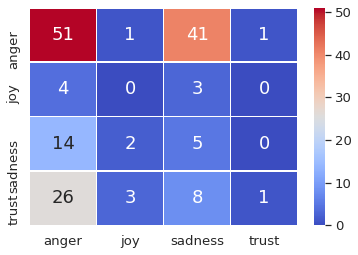

In [65]:
# preprocessing the data
# for this initial stage we work only with the first sentence of each comment
comments = tokenize_firstsentence(comments.array)
comments = [' '.join(x) for x in comments]

# preprocessing the text
comments_cv = cv_trained.transform(comments)
# preprocessing the labels
sentiments_lb = lb_trained.transform(sentiments)

# predicting and evaluating the labels
sentiments_svm = predict_svm(X_train_cv, y_train_lb, comments_cv)
show_eval(sentiments_lb, sentiments_svm, lb_trained, labels)

The results are not encouraging. Even with only 4 categories, the predictions are confused between them. While we were annotating comments manually, we could see that it was difficult to distinguish sadness from anger, and joy from trust. Therefore, we are going to simplify the sentiment analysis and to reduce the classification to only 2 categories : *positive* and *negative*.

## 2.2 Sentiment analysis with positive and negative

### 2.2.1 Training with labelled tweets

In [66]:
# limiting sentiments to positive and negative
y = dfTweets.sentiment
y = y.replace(["neutral","worry","sadness","surprise","hate","empty","boredom","anger"],"negative")
y = y.replace(["happiness","love","fun","relief","enthusiasm"],"positive")
y.value_counts()

negative    26888
positive    13112
Name: sentiment, dtype: int64

In [67]:
# preprocessing the data
X_train_cv, X_dev_cv, X_test_cv, y_train_lb, y_dev_lb, y_test_lb, cv_trained, lb_trained = preprocess_data(X,y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[LibLinear]/n
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80      5411
    positive       0.58      0.51      0.54      2589

    accuracy                           0.72      8000
   macro avg       0.68      0.66      0.67      8000
weighted avg       0.71      0.72      0.71      8000



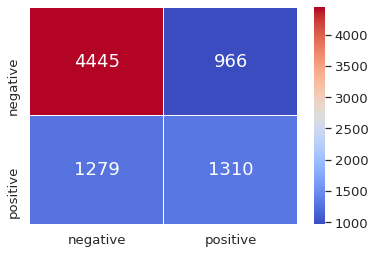

In [68]:
# predicting the labels and evaluating the predictions
y_pred_svm = predict_svm(X_train_cv, y_train_lb, X_dev_cv)
labels = ['negative', 'positive']
show_eval(y_dev_lb, y_pred_svm, lb_trained, labels)

### 2.2.2 Testing on the annoted comments

In [69]:
# limiting to pos and neg
sentiments = sentiments.replace(["sadness","anger","trust","joy"],["negative","negative","positive","positive"])
print(sentiments.value_counts())

negative    115
positive     45
Name: sentiment, dtype: int64


[LibLinear]/n
              precision    recall  f1-score   support

    negative       0.72      0.87      0.79       115
    positive       0.32      0.16      0.21        45

    accuracy                           0.67       160
   macro avg       0.52      0.51      0.50       160
weighted avg       0.61      0.67      0.63       160



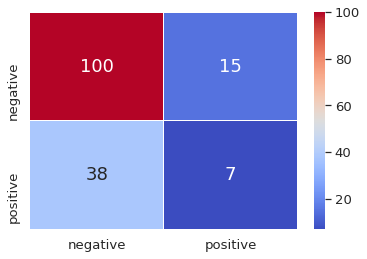

In [70]:
# preprocessing the labels
sentiments_lb = lb_trained.transform(sentiments)

# predicting and evaluating the labels
sentiments_svm = predict_svm(X_train_cv, y_train_lb, comments_cv)
show_eval(sentiments_lb, sentiments_svm, lb_trained, labels)

We can see that with only 2 categories, it is still difficult to precisely identify positive emotions. The predictions on the tweets are good for detecting negative emotions, but completely confused in front of positive tweets. The results are even worse on our small dataset of annotated comments. The reason might be that we have very few comments, and the proportion of negative comments greatly outnumber the positive ones.  
All in all, in regard to our results, we consider that the dataset of labelled tweets is not suitable to train our algorithms for our sentiment analysis.

# 3. TEXT CLASSIFICATION WITH COMMENTS LABELLED FROM A DICTIONNARY

We are going to use labels created with a dictionary of words. We keep in this part only the first sentence for each comment because we try a simple approach with SVM and Random Forest to predict the emotions. In the next part, we will study the comments as a whole.

## 3.1 Sentiment analysis with 4 emotions

In [71]:
train = pd.read_csv('train_one_sentiment.csv', sep = "\t", error_bad_lines=False)
test = pd.read_csv('test_one_sentiment.csv', sep = "\t", error_bad_lines=False)
dev = pd.read_csv('dev_one_sentiment.csv', sep = "\t", error_bad_lines=False)
train.head()

,commentBody,anger,sadness,trust,joy
0,i was an athlete in a minor sport at a big ten...,0,0,0,1
1,"republicans do have a mandate, voters gave the...",0,0,0,1
2,this article has only served to reinforce that...,0,1,0,0
3,"in other words, he followed to the letter the ...",0,0,0,1
4,great editorial!,1,0,0,0


In [73]:
train["sentiment"] = train[["anger","sadness","trust","joy"]].idxmax(axis=1)
test["sentiment"] = test[["anger","sadness","trust","joy"]].idxmax(axis=1)
dev["sentiment"] = dev[["anger","sadness","trust","joy"]].idxmax(axis=1)
train.sentiment.value_counts()

anger      2573
joy        1368
trust      1211
sadness    1127
Name: sentiment, dtype: int64

In [0]:
# preparing datasets
X_train = train.commentBody
X_dev = dev.commentBody
X_test = test.commentBody

y_train = train.sentiment
y_dev = dev.sentiment
y_test = test.sentiment

In [75]:
# preprocessing
X_train_cv, X_dev_cv, X_test_cv, y_train_lb, y_dev_lb, y_test_lb, cv_trained, lb_trained = preprocess_splitteddata(X_train,X_dev,X_test,y_train,y_dev,y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


### 3.1.1 Predicting with SVM

[LibLinear][LibLinear][LibLinear][LibLinear]/n
              precision    recall  f1-score   support

       anger       0.65      0.92      0.76       852
         joy       0.70      0.56      0.62       448
     sadness       0.76      0.50      0.61       401
       trust       0.69      0.47      0.56       392

    accuracy                           0.68      2093
   macro avg       0.70      0.61      0.64      2093
weighted avg       0.69      0.68      0.67      2093



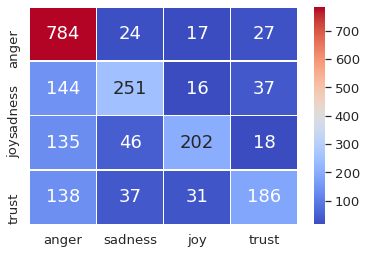

In [76]:
# predicting the labels and evaluating the predictions with SVM
y_pred_svm = predict_svm(X_train_cv, y_train_lb, X_dev_cv)
labels = ['anger','sadness', 'joy','trust']
show_eval(y_dev_lb, y_pred_svm, lb_trained, labels)

The results show a good accuracy. We consider that these labels are good enough to be used in our sentiment analysis.

### 3.1.2 Predicting with Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.4s finished


/n
              precision    recall  f1-score   support

       anger       0.43      1.00      0.60       852
         joy       0.93      0.06      0.11       448
     sadness       0.89      0.08      0.15       401
       trust       0.82      0.14      0.24       392

    accuracy                           0.46      2093
   macro avg       0.77      0.32      0.28      2093
weighted avg       0.70      0.46      0.34      2093



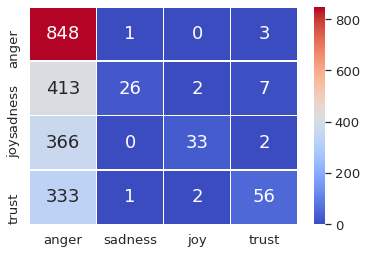

In [77]:
# predicting the labels and evaluating the predictions with Random Forest
y_pred_rfc = predict_randomforest(X_train_cv, y_train_lb, X_dev_cv)
labels = ['anger','sadness', 'joy','trust']
show_eval(y_dev_lb, y_pred_rfc, lb_trained, labels)

In [78]:
# optimizing parameters for the Random Forest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

forest = RandomForestClassifier(n_jobs=-1, verbose=1)

distributions = dict(n_estimators=randint(0, 400), 
                     max_depth=randint(10, 40),
                     min_samples_split = randint(1, 20),
                     min_samples_leaf = randint(1, 20))

clf = RandomizedSearchCV(forest, distributions, random_state=42, n_iter = 10)
search = clf.fit(X_train_cv, y_train_lb)
search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0

{'max_depth': 37,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 313}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 313 out of 313 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/n
              precision    recall  f1-score   support

       anger       0.44      1.00      0.61       912
         joy       0.00      0.00      0.00       415
     sadness       1.00      0.02      0.03       352
       trust       1.00      0.00      0.00       415

    accuracy                           0.44      2094
   macro avg       0.61      0.25      0.16      2094
weighted avg       0.56      0.44      0.27      2094



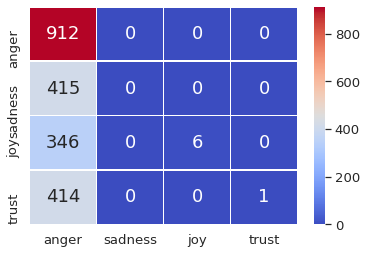

In [79]:
forestOpt = RandomForestClassifier(n_jobs=-1, verbose=1, max_depth = 37, min_samples_leaf = 1,
                                   min_samples_split = 12, n_estimators = 313, random_state = 42)

forestOpt.fit(X_train_cv, y_train_lb)
y_pred_opt = forestOpt.predict(X_test_cv)
show_eval(y_test_lb, y_pred_opt, lb_trained, labels)

### 3.1.3 Predicting the emotion of each comments

In [80]:
dfComments = pd.read_csv('Comments.csv')
# keeping only comments with a section name
dfComments = dfComments[dfComments['sectionName']!="Unknown"]
comments = dfComments.commentBody

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
# preprocessing the text
# keeping only the first sentence of each comment
comments = tokenize_firstsentence(comments.array)
comments = [' '.join(x) for x in comments]
comments_cv = cv_trained.transform(comments)

# predicting and evaluating the labels with SVM
sentiments_svm = predict_svm(X_train_cv, y_train_lb, comments_cv)

# predicting and evaluating the labels with Random Forest
sentiments_rfc = predict_randomforest(X_train_cv, y_train_lb, comments_cv)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



[LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:   18.5s finished


In [0]:
# writing predictions with the real label name
sentiments_svm_names = lb_trained.inverse_transform(sentiments_svm)
sentiments_rfc_names = lb_trained.inverse_transform(sentiments_rfc)
dfComments['sentiments_svm'] = sentiments_svm_names
dfComments['sentiments_rfc'] = sentiments_rfc_names

## 3.2. Sentiment analysis with positive and negative

In [83]:
train = pd.read_csv('train_one.csv', sep = "\t", error_bad_lines=False)
test = pd.read_csv('test_one.csv', sep = "\t", error_bad_lines=False)
dev = pd.read_csv('dev_one.csv', sep = "\t", error_bad_lines=False)
train.head()

,commentBody,sentiment
0,some in the diplomatic circles here are saying...,1
1,"indeed, and as you can often judge someone by ...",0
2,who knew organizing concerts on tropical islan...,0
3,the war on poverty declared by the republicans...,0
4,i fear the new army of trump ice enforcers wil...,0


In [84]:
# reducing the size of the datasets because it is too heavy for SVM otherwise
train = train.iloc[:12000,]
test = test.iloc[:4000,]
dev = dev.iloc[:4000,]
train.shape

(12000, 2)

In [85]:
# preparing datasets
X_train = train.commentBody
X_dev = dev.commentBody
X_test = test.commentBody

y_train = train.sentiment.replace([0,1],["negative","positive"])
y_dev = dev.sentiment.replace([0,1],["negative","positive"])
y_test = test.sentiment.replace([0,1],["negative","positive"])
print(y_train.value_counts())

negative    8146
positive    3854
Name: sentiment, dtype: int64


In [86]:
# preprocessing
X_train_cv, X_dev_cv, X_test_cv, y_train_lb, y_dev_lb, y_test_lb, cv_trained, lb_trained = preprocess_splitteddata(X_train,X_dev,X_test,y_train,y_dev,y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


### 3.2.1 Predicting with SVM

[LibLinear]/n
              precision    recall  f1-score   support

    negative       0.91      0.92      0.91      2695
    positive       0.83      0.82      0.82      1305

    accuracy                           0.89      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.88      0.89      0.88      4000



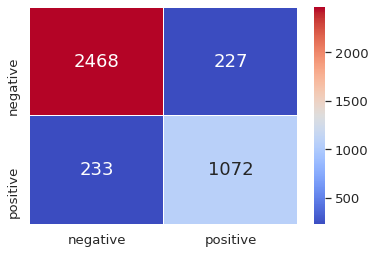

In [87]:
# predicting the labels and evaluating the predictions with SVM
y_pred_svm = predict_svm(X_train_cv, y_train_lb, X_dev_cv)
labels = ['negative', 'positive']
show_eval(y_dev_lb, y_pred_svm, lb_trained, labels)

Once again, the results show a satisfying accuracy.

### 3.2.2 Predicting with Random Forest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.8s finished


/n
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87      2695
    positive       0.73      0.74      0.74      1305

    accuracy                           0.83      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.83      0.83      0.83      4000



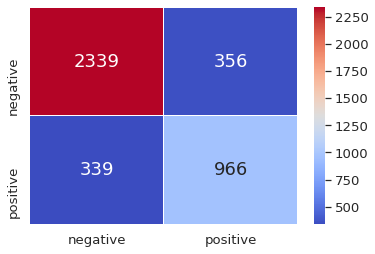

In [88]:
# predicting the labels and evaluating the predictions with Random Forest
y_pred_rfc = predict_randomforest(X_train_cv, y_train_lb, X_dev_cv)
labels = ['negative', 'positive']
show_eval(y_dev_lb, y_pred_rfc, lb_trained, labels)

In [89]:
# optimizing parameters for the Random Forest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

forest = RandomForestClassifier(n_jobs=-1, verbose=1)

distributions = dict(n_estimators=randint(0, 400), 
                     max_depth=randint(10, 40),
                     min_samples_split = randint(1, 20),
                     min_samples_leaf = randint(1, 20))

clf = RandomizedSearchCV(forest, distributions, random_state=42, n_iter = 10)
search = clf.fit(X_train_cv, y_train_lb)
search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent wor

{'max_depth': 37,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 313}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 313 out of 313 | elapsed:    0.2s finished


/n
              precision    recall  f1-score   support

    negative       0.69      1.00      0.82      2721
    positive       0.88      0.06      0.12      1279

    accuracy                           0.70      4000
   macro avg       0.79      0.53      0.47      4000
weighted avg       0.75      0.70      0.59      4000



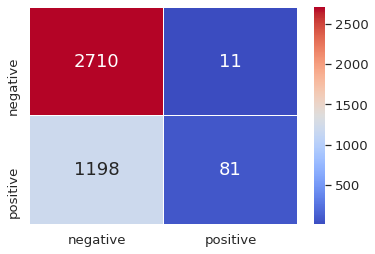

In [90]:
forestOpt = RandomForestClassifier(n_jobs=-1, verbose=1, max_depth = 37, min_samples_leaf = 1,
                                   min_samples_split = 12, n_estimators = 313, random_state = 42)

forestOpt.fit(X_train_cv, y_train_lb)
y_pred_opt = forestOpt.predict(X_test_cv)
show_eval(y_test_lb, y_pred_opt, lb_trained, labels)

### 3.2.3 Predicting the emotions of each comments

In [92]:
# preprocessing the text
comments_cv = cv_trained.transform(comments)

# predicting and evaluating the labels with SVM
sentiments_svm = predict_svm(X_train_cv, y_train_lb, comments_cv)

# predicting and evaluating the labels with Random Forest
sentiments_rfc = predict_randomforest(X_train_cv, y_train_lb, comments_cv)

[LibLinear]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:   17.7s finished


In [0]:
# writing predictions with the real label name
sentiments_svm_names = lb_trained.inverse_transform(sentiments_svm)
sentiments_rfc_names = lb_trained.inverse_transform(sentiments_rfc)
dfComments['sentiments_svm_posneg'] = sentiments_svm_names
dfComments['sentiments_rfc_posneg'] = sentiments_rfc_names

# 4. TEXT CLASSIFICATION WITH BERT (NEGATIVE AND POSITIVE CLASSIFICATION)

## 4.1. Pre-processing and modeling with BERT

*   Uploading transformer

In [94]:
!pip install transformers

     |████████████████████████████████| 573kB 8.8MB/s 
     |████████████████████████████████| 1.0MB 58.8MB/s 
     |████████████████████████████████| 870kB 52.0MB/s 
     |████████████████████████████████| 3.7MB 45.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=d4b170ca317f3f852b18672df4cd6cf46b7e1cb3037702d2848548c218c1ab10
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


*  Importing pytorch and BERT packages

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer
from torch.utils.data import DataLoader

*  Preprocessing

We introduce a few preprocessing function to help you get to the model.

SSTDataset is a class that handle get, tokenization and padding of the sentences.


In [0]:
class SSTDataset(Dataset):

    def __init__(self, filename, maxlen, model_name='bert-base-uncased'):

        #Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter = '\t',  lineterminator='\n')

        #Initialize the BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        #Selecting the comments and label at the specified index in the data frame
        sentence = self.df.loc[index, 'commentBody']
        label = self.df.loc[index, 'sentiment']

        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the comment
        if self.tokenizer.cls_token is None:
          bos_token = self.tokenizer.bos_token
        else:
          bos_token = self.tokenizer.cls_token
          
        if self.tokenizer.sep_token is None:
          eos_token = self.tokenizer.eos_token
        else:
          eos_token = self.tokenizer.sep_token
        
        tokens = [bos_token] + tokens + [eos_token] #Insering the CLS and SEP token in the beginning and end of the comment
        if len(tokens) < self.maxlen:
            tokens = tokens + [self.tokenizer.pad_token for _ in range(self.maxlen - len(tokens))] #Padding comments
        else:
            tokens = tokens[:self.maxlen-1] + [eos_token] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

*   Creating instances of training and validation set



In [0]:
train_set = SSTDataset(filename = 'train_one.csv', maxlen=50, model_name='bert-base-uncased')
val_set = SSTDataset(filename = 'dev_one.csv', maxlen=50, model_name='bert-base-uncased')

*    Creating intsances of training and validation dataloaders

In [0]:
train_loader = DataLoader(train_set, batch_size = 128, num_workers = 5)
val_loader = DataLoader(val_set, batch_size = 128, num_workers = 5)

*   Get the number of comments

In [121]:
print(train_set.__len__(), "number of comment in training set")
print(val_set.__len__(), "number of comment in validation set")

63542 number of comment in training set
21181 number of comment in validation set


*   Define the Sentiment Analysis model using pytorch

The class withto instansiate the model and forward() method to define the foward pass.

We will use the pretrained Masked Language Model as one module of our sentiment analysis model.

In [0]:
class SentimentClassifier(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(SentimentClassifier, self).__init__()
        
        #we will use the pretrained Masked Language Model as one module of our sentiment analysis model
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        #we append an extra layer for Classification (it will be randomly initialized)
        self.cls_layer = nn.Linear(self.encoder.pooler.dense.out_features, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps, _ = self.encoder(seq, attention_mask = attn_masks)

        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits

In [123]:
sentiment_model = SentimentClassifier('bert-base-uncased')
sentiment_model = sentiment_model.to("cuda")
sentiment_model.cls_layer.weight.is_cuda

True

*   Defining training process

We define a loss (BCE with logits loss because we are doing a binary classification) and an optimizer (a variant of stochastic gradient Ddscent called ADAM) with a specific learning rate.



In [0]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
opti = optim.Adam(sentiment_model.parameters(), lr = 1e-5)

*   Training function

In [0]:
import pdb
training_stats = []

def train(model, criterion, opti, train_loader, val_loader, max_eps=1, gpu=False, print_every=1,validate_every=1):
    if gpu:
      model = model.to("cuda")
    for ep in range(max_eps):
        total_train_loss = 0
        total_train_accuracy = 0
        n_batch_test = 0
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            #Clear gradients
            opti.zero_grad()  
            #Converting these to cuda tensors
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits = model(seq, attn_masks)

            #Computing loss
            loss = criterion(logits.squeeze(-1), labels.float())

            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()
            if (it + 1) % print_every == 0:
                accuracy = torch.sum((logits>0).int().squeeze(1)==labels)/float(labels.size(0))
                print("Iteration {} of epoch {} complete. Loss : {}, Accuracy {} ".format(it+1, ep+1, loss.item(),accuracy))
            if it>1000:
              break
        total_train_loss += loss.item()
        total_train_accuracy += accuracy
        n_batch_test += 1        
        if ep % validate_every==0:
          n_batch_validation = 0
          loss_validation = 0
          accuracy_validation = 0
          for it, (seq, attn_masks, labels) in enumerate(val_loader):
            #Clear gradients
            
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits_val = model(seq, attn_masks)
            n_batch_validation+=1
            #Computing loss
           
            _loss = float(criterion(logits_val.squeeze(-1), labels.float()))
            _accu = float(torch.sum((logits_val>0).int().squeeze(1)==labels)/float(labels.size(0)))
           
            loss_validation += _loss
            accuracy_validation += _accu
          print("EVALUATION Validation set : mean loss {} n mean accuracy {}".format(loss_validation/n_batch_validation, accuracy_validation/n_batch_validation))
        avg_train_loss = total_train_loss/n_batch_validation    
        avg_train_accuracy = total_train_accuracy/n_batch_validation
        training_stats.append({'epoch': ep + 1, 'Training Loss': avg_train_loss, 'Training Accuracy': avg_train_accuracy, 'Valid. Loss': loss_validation/n_batch_validation, 'Valid. Accuracy': accuracy_validation/n_batch_validation})    

We can choose the number of epochs (max_eps), the display frequency (print_every) and the use of gpu (gpu).

## 4.2. Training with comments labelled from a dictionary

In [126]:
train(sentiment_model, criterion, opti, train_loader, val_loader, max_eps=5, print_every=100, gpu=True)

Iteration 100 of epoch 1 complete. Loss : 0.3351566195487976, Accuracy 0.859375 
Iteration 200 of epoch 1 complete. Loss : 0.36769890785217285, Accuracy 0.8671875 
Iteration 300 of epoch 1 complete. Loss : 0.2561355531215668, Accuracy 0.8828125 
Iteration 400 of epoch 1 complete. Loss : 0.2635982632637024, Accuracy 0.90625 
EVALUATION Validation set : mean loss 0.17136344892612423 n mean accuracy 0.9335798621177673
Iteration 100 of epoch 2 complete. Loss : 0.13482871651649475, Accuracy 0.9375 
Iteration 200 of epoch 2 complete. Loss : 0.17636734247207642, Accuracy 0.9375 
Iteration 300 of epoch 2 complete. Loss : 0.11972206830978394, Accuracy 0.9375 
Iteration 400 of epoch 2 complete. Loss : 0.11146217584609985, Accuracy 0.953125 
EVALUATION Validation set : mean loss 0.1341675687805716 n mean accuracy 0.9480282807924661
Iteration 100 of epoch 3 complete. Loss : 0.08102641999721527, Accuracy 0.9765625 
Iteration 200 of epoch 3 complete. Loss : 0.13906848430633545, Accuracy 0.9453125 
I

*   Creating a dataframe from our training statistics

In [127]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Training Accuracy,Valid. Loss,Valid. Accuracy
epoch,,,,
1,0.001860,"tensor(0.0055, device='cuda:0')",0.171363,0.933580
2,0.000891,"tensor(0.0057, device='cuda:0')",0.134168,0.948028
3,0.000242,"tensor(0.0060, device='cuda:0')",0.150222,0.949723
4,0.000008,"tensor(0.0060, device='cuda:0')",0.172798,0.953488
5,0.000027,"tensor(0.0060, device='cuda:0')",0.208609,0.950899


*   Plotting training & validation loss


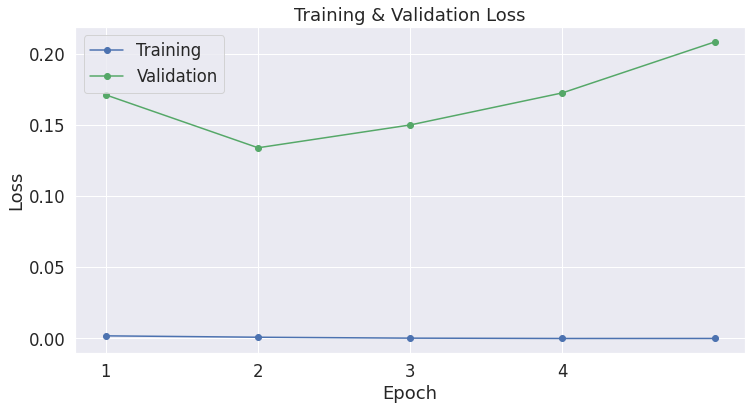

In [128]:
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

We can see that we are overfitting the data.

## 4.3. Testing on the comments labelled from a dictionary

*    Creating testing set and test loader

In [0]:
test_set = SSTDataset(filename = 'test_one.csv', maxlen=30, model_name='bert-base-uncased')
test_loader = DataLoader(test_set, batch_size = 128, num_workers = 5)

We display the number of comments in the testing set.

In [130]:
print(test_set.__len__(), "number of comments in testing set")

21181 number of comments in testing set


*   Evaluation function

In [0]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

In [0]:
sentiment_model.eval()
predictions, true_labels = [], []
device = torch.device("cuda")

for it, (seq, attn_masks, labels) in enumerate(test_loader):
  # Add batch to GPU
  seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = sentiment_model(seq, attn_masks)
  # Move logits and labels to CPU
  logits = outputs.detach().cpu().numpy()
  label_ids = labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append((sigmoid(logits[:, 0]) > 0.5)*1)
  true_labels.append(label_ids)

In [0]:
predictions_mer = np.array([j for i in predictions for j in i])
true_labels_mer = np.array([j for i in true_labels for j in i])

*  F1 score

In [153]:
from sklearn.metrics import classification_report

print(classification_report(true_labels_mer, predictions_mer))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     14399
           1       0.91      0.88      0.89      6782

    accuracy                           0.93     21181
   macro avg       0.93      0.92      0.92     21181
weighted avg       0.93      0.93      0.93     21181



*   Evaluation display

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

def show_eval_bert(y_true, y_pred, labels):
  cm = confusion_matrix(y_true, y_pred) 
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)

  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

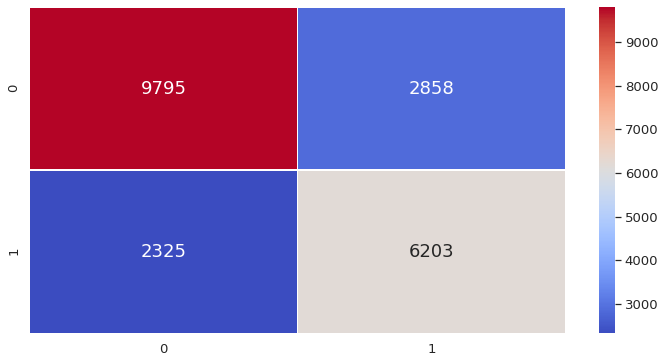

negative 0.7507466907120633
positive 0.7507466907120632


In [0]:
show_eval_bert(true_labels_mer, predictions_mer, ['0', '1'])

## 4.4 Predicting the positive or negative emotions generated by the topic of the article

*  Retrieving all comments

In [157]:
comments_final = dfComments[['commentBody']]
comments_final['sentiment'] = np.nan
comments_final['commentBody'] = comments_final['commentBody'].str.replace('<br/>', ' ').str.replace('@', '')
comments_final['commentBody'] = comments_final['commentBody'].str.lower()
comments_final.to_csv('comments_final.csv', sep='\t', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

*    Creating comments set and comments loader

In [0]:
comments_set = SSTDataset(filename = 'comments_final.csv', maxlen=30, model_name='bert-base-uncased')
comments_loader = DataLoader(comments_set, batch_size = 128, num_workers = 5)

In [159]:
print(comments_set.__len__(), "number of comments in the entire set")

105904 number of comments in the entire set


*   Evaluation function

In [0]:
sentiment_model.eval()
predictions, true_labels = [], []
device = torch.device("cuda")

for it, (seq, attn_masks, labels) in enumerate(comments_loader):
  # Add batch to GPU
  seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = sentiment_model(seq, attn_masks)
  # Move logits and labels to CPU
  logits = outputs.detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append((sigmoid(logits[:, 0]) > 0.5)*1)

In [162]:
predictions_mer = np.array([j for i in predictions for j in i])
comments_final['sentiment'] = predictions_mer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We rename labels '0' as 'negative' and labels '1' as 'positive'.

In [163]:
comments_final['sentiment'].replace({0: "negative", 1: "positive"}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


*  Adding a column with BERT's predictions in the global dataframe

In [0]:
dfComments['sentiments_BERT'] = comments_final['sentiment'] 

# 5. TEXT CLASSIFICATION WITH KERAS AND GLOVE (SENTIMENT CLASSIFICATION)

---



## 5.1. Pre-processing and modeling with Keras and GloVe

*   Uploading datasets



In [0]:
train_sentiment = pd.read_csv('train_one_sentiment.csv', sep = "\t")
test_sentiment = pd.read_csv('test_one_sentiment.csv', sep = "\t")
dev_sentiment = pd.read_csv('dev_one_sentiment.csv', sep = "\t")

*   Separating labels and comments

In [0]:
X_train = train_sentiment[train_sentiment.columns[0]]
y_train = train_sentiment[train_sentiment.columns[1:].tolist()]
X_test = test_sentiment[test_sentiment.columns[0]]
y_test = test_sentiment[test_sentiment.columns[1:].tolist()]
labels = y_train.columns.values.tolist()

*   Importing Keras packages

In [168]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


*   Tokenization and word embeddings with GloVe

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 200
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

We download GloVE.

In [170]:
!wget 'http://nlp.stanford.edu/data/glove.6B.zip'

--2020-04-12 14:11:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-12 14:11:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-12 14:11:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [171]:
!unzip 'glove.6B.zip'

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [172]:
word_index = tokenizer.word_index

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


*  Model creation

In [0]:
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.layers import Flatten, LSTM
from tensorflow.python.keras.layers.core import Activation, Dropout, Dense
from tensorflow.python.keras.models import Model

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(len(labels), activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Here are some features of this model:

In [174]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          1236200   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 1,353,964
Trainable params: 117,764
Non-trainable params: 1,236,200
_________________________________________________________________
None


## 5.2. Training with comments labelled from a dictionary

*   Training function

In [175]:
history = model.fit(X_train, y_train, batch_size=6, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
838/838 [==============================] - 12s 14ms/step - loss: 0.5462 - acc: 0.4087 - val_loss: 0.5419 - val_acc: 0.4132
Epoch 2/5
838/838 [==============================] - 11s 13ms/step - loss: 0.5422 - acc: 0.4093 - val_loss: 0.5403 - val_acc: 0.4132
Epoch 3/5
838/838 [==============================] - 11s 13ms/step - loss: 0.5420 - acc: 0.4095 - val_loss: 0.5434 - val_acc: 0.4132
Epoch 4/5
838/838 [==============================] - 12s 14ms/step - loss: 0.5416 - acc: 0.4093 - val_loss: 0.5427 - val_acc: 0.4132
Epoch 5/5
838/838 [==============================] - 12s 14ms/step - loss: 0.5414 - acc: 0.4093 - val_loss: 0.5399 - val_acc: 0.4132


## 5.3. Testing on the comments labelled from a dictionary

In [176]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

66/66 [==============================] - 1s 8ms/step - loss: 0.5353 - acc: 0.4351
Test Score: 0.5353171229362488
Test Accuracy: 0.4350525438785553


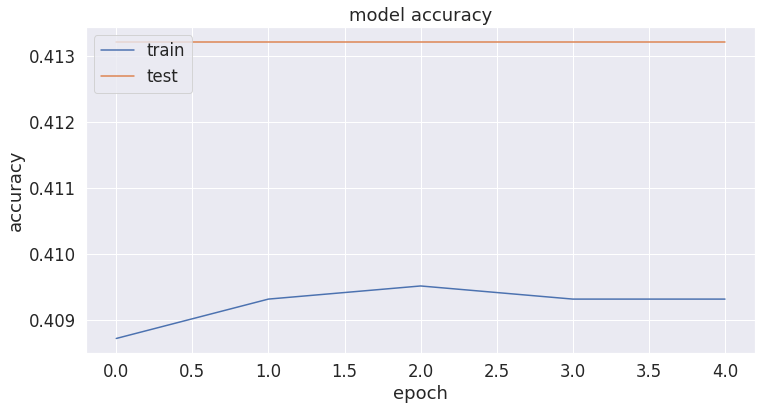

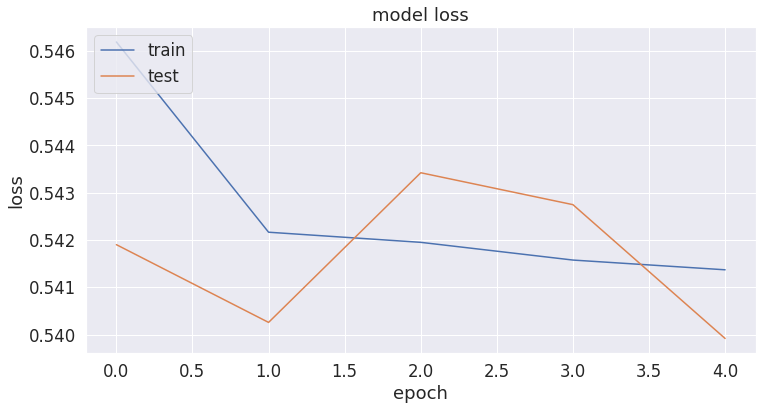

In [177]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# 6. WHICH EMOTIONS ARE TRIGGERED BY THE NEW YORK TIME'S DIFFERENT TOPICS?




In [0]:
# evaluating the major emotion generated by a topic
def evaluate_emotions(dfComments, nyt_emotions, clf, labels):

  # defining a column to store the major emotion generated by each topic according to the prediction of classifier clf
  nyt_emotions["max_"+clf] = 0

  for topic in nyt_emotions.section:

    # getting the numbers of comments for each sentiment by section 
    sentiments_numbers = dfComments.loc[dfComments["sectionName"]==topic, "sentiments_"+clf].value_counts()

    # writing the emotion that got the maximum of comments in this section
    nyt_emotions.loc[nyt_emotions["section"]==topic,"max_"+clf] = sentiments_numbers.index.values[0]

  return(nyt_emotions)

In [0]:
# creating a dataset to register the dominant emotion expressed in a section
section_names = dfComments.sectionName.unique()
nyt_emotions = pd.DataFrame({'section': section_names}) 

In [190]:
# adding predictions made with SVM and Random Forest with 4 emotions
labels = ["anger", "joy", "sadness", "trust"]
nyt_emotions = evaluate_emotions(dfComments, nyt_emotions, "svm", labels)
nyt_emotions = evaluate_emotions(dfComments, nyt_emotions, "rfc", labels)
print(nyt_emotions)

               section max_svm max_rfc
0   College Basketball   anger   anger
1                Media   anger   anger
2             Politics   anger   anger
3             Baseball   anger   anger
4        Sunday Review   anger   anger
5       Pro Basketball   anger   anger
6           Television   anger   anger
7         Asia Pacific   anger   anger
8               Family   anger   anger
9                 Live   anger   anger
10      Education Life   anger   anger
11              Hockey   anger   anger
12        Lesson Plans     joy   anger
13         Middle East   anger   anger
14                Move   anger   anger
15               Music   anger   anger
16                Mind   anger   anger
17              Soccer   anger   anger
18            DealBook   anger   anger
19                Golf   anger   anger
20                 Eat   anger   anger
21       Student Loans   anger   anger
22             Economy   anger   anger
23        Art & Design   anger   anger
24         Book Review   

In [191]:
# adding predictions made with SVM and Random Forest with 2 emotions
labels = ["negative", "positive"]
nyt_emotions = evaluate_emotions(dfComments, nyt_emotions, "svm_posneg", labels)
nyt_emotions = evaluate_emotions(dfComments, nyt_emotions, "rfc_posneg", labels)
print(nyt_emotions)

               section max_svm max_rfc max_svm_posneg max_rfc_posneg
0   College Basketball   anger   anger       negative       negative
1                Media   anger   anger       negative       negative
2             Politics   anger   anger       negative       negative
3             Baseball   anger   anger       negative       negative
4        Sunday Review   anger   anger       negative       negative
5       Pro Basketball   anger   anger       negative       negative
6           Television   anger   anger       negative       negative
7         Asia Pacific   anger   anger       negative       negative
8               Family   anger   anger       negative       negative
9                 Live   anger   anger       negative       negative
10      Education Life   anger   anger       negative       negative
11              Hockey   anger   anger       negative       negative
12        Lesson Plans     joy   anger       positive       positive
13         Middle East   anger   a

In [192]:
# adding predictions made with BERT with 2 emotions
labels = ["negative", "positive"]
nyt_emotions = evaluate_emotions(dfComments, nyt_emotions, "BERT", labels)
print(nyt_emotions)

               section max_svm max_rfc max_svm_posneg max_rfc_posneg  max_BERT
0   College Basketball   anger   anger       negative       negative  negative
1                Media   anger   anger       negative       negative  negative
2             Politics   anger   anger       negative       negative  negative
3             Baseball   anger   anger       negative       negative  negative
4        Sunday Review   anger   anger       negative       negative  negative
5       Pro Basketball   anger   anger       negative       negative  negative
6           Television   anger   anger       negative       negative  negative
7         Asia Pacific   anger   anger       negative       negative  negative
8               Family   anger   anger       negative       negative  negative
9                 Live   anger   anger       negative       negative  negative
10      Education Life   anger   anger       negative       negative  negative
11              Hockey   anger   anger       negativ